In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai.text.all import *
from torch.utils.data import Dataset
from reformer_fastai.reformer import LSHLM

In [ ]:
#hide
#skip
torch.cuda.set_device(7)

In [ ]:
#all_slow

# Comparing LSH implementations

Compare performance for LSH between implementations on the syntethich task of the reformer paper.

## Create dataset

Copied from synthetic task notebook. Consider adding to `core`.

In [ ]:
class TwinSequence(Dataset):
    def __init__(self, sl=1024, len=100):
        assert sl%2 == 0
        self.sl = sl
        self.len = len
    def __getitem__(self, idx):
        seq = torch.randint(1,128,(self.sl//2,))             # w: [1-127] of len sl//2
        seq[0] = 0                                           # seq = 0w
        seq = torch.cat((seq,seq), -1)                       # seq = 0w0w
        target = torch.cat((seq[1:],torch.tensor([0])), -1)  # return offset target x:[0123], y:[1230]
        return (seq, target)                     
    def __len__(self):
        return self.len

class MaskTargCallback(Callback):
    def before_batch(self):
        self.y[:, :self.dls.train_ds.sl//2] = -100

def masked_accuracy(inp, targ, ignore=-100):
    pred = inp.argmax(dim=-1)
    mask = targ[0] != ignore
    return (pred[:,mask] == targ[:,mask]).float().mean()

## Long sequence modelling

Sequence length of 1024, similar what is used in the paper.

In [ ]:
bs, sl = 32,1024
n_epochs = 5
train_sz = 50_000
valid_sz = 10_000
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=bs, shuffle=False, device='cuda')

Total training steps:

In [ ]:
len(dls.train)*n_epochs

7810

### Our implementation - LSHLM

We set `n_hashes` to 1. The paper reach around 80% masked accuracy with this setup. Other hyperparameters aren't specified in the paper.

In [ ]:
n_hashes=1
bucket_size = 64
assert sl % (bucket_size * 2) == 0

In [ ]:
model = LSHLM(vocab_sz=128, d_model=256, n_layers=1, n_heads=4, max_seq_len=sl,
              bucket_size=bucket_size, n_hashes=n_hashes, causal=True)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback()])
learn.fit_one_cycle(n_epochs, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,4.835418,4.835315,0.009802,02:11
1,4.834976,4.834967,0.009811,02:11
2,4.834833,4.834830,0.009913,02:10
3,4.834765,4.834762,0.009814,02:08
4,4.834752,4.834729,0.009791,02:12


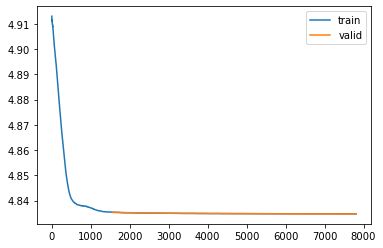

In [ ]:
learn.recorder.plot_loss()

In [ ]:
del learn
torch.cuda.empty_cache()

As expected per the paper results, the model struggles with learning the task.

### Our implementation - Reformer LM

Let's try our `ReformerLM`

In [ ]:
from reformer_fastai.reformer import ReformerLM as fastReformerLM

In [ ]:
n_hashes=1
bucket_size = 64
assert sl % (bucket_size * 2) == 0

In [ ]:
model = fastReformerLM(128, 256, d_ff=256, n_layers=1, n_heads=4, max_seq_len=sl,attn_dropout=0,
                   ff_dropout=0, bucket_size=bucket_size, n_hashes=n_hashes, causal=True)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback()])
learn.fit_one_cycle(n_epochs, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,4.839448,4.838953,0.009965,02:35
1,4.838668,4.837892,0.009768,02:40
2,4.836806,4.836470,0.009905,02:37
3,4.835473,4.835377,0.009865,02:39
4,4.835098,4.835018,0.009851,02:37


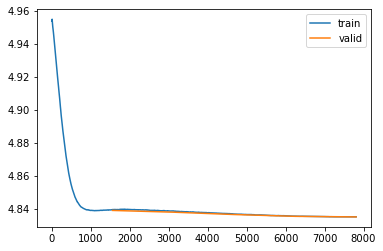

In [ ]:
learn.recorder.plot_loss()

In [ ]:
del learn
torch.cuda.empty_cache()

> Similar performance as `LSHLM`.

### Lucidrains implementation - Reformer LM

Testing [lucidrains implementation](https://github.com/lucidrains/reformer-pytorch/).

In [ ]:
from reformer_pytorch import ReformerLM

In [ ]:
n_hashes=1
bucket_size = 64
assert sl % (bucket_size * 2) == 0

In [ ]:
model = ReformerLM(num_tokens=128, dim=256, depth=1, max_seq_len = sl, heads=4, bucket_size=bucket_size, 
          n_hashes=n_hashes, causal=True)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback()])
learn.fit_one_cycle(n_epochs, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,4.837056,4.837096,0.009853,04:41
1,4.835596,4.835464,0.009837,04:46
2,4.835036,4.835006,0.009834,04:44
3,4.834813,4.834811,0.009827,04:44
4,4.834746,4.834740,0.009795,04:38


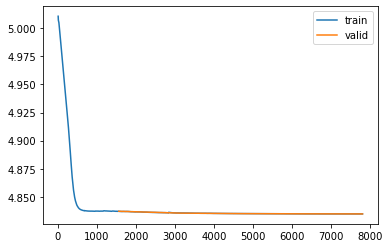

In [ ]:
learn.recorder.plot_loss()

In [ ]:
del learn
torch.cuda.empty_cache()

> This implementation has similar performance to our `LSHLM`